In [1]:
import re
import nltk
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from google_trans_new import google_translator  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn import preprocessing
import typing
import numpy as np
import pandas as pd

In [2]:
fg_df = pd.read_csv('D:/Users/ehern/Desktop/Machine Learning/Project/fall_guys_metacritic_reviews.csv')

fg_df.head()

,username,review_type,published_date,score,votes,review_text,profile_url,platform
0,Fen1ma,user,"Aug 26, 2020",6.0,0.0,"на данный момент не советую покупать игру, ещё...",https://www.metacritic.com/user/Fen1ma,pc
1,Locke_VI,user,"Aug 25, 2020",3.0,0.0,Fall Guys was a game I was really looking forw...,https://www.metacritic.com/user/Locke_VI,pc
2,Crisener,user,"Aug 25, 2020",8.0,0.0,You gotta love it. The aesthetics are very col...,https://www.metacritic.com/user/Crisener,pc
3,EnigmaXtreme,user,"Aug 25, 2020",7.0,0.0,When we covered Fall Guys last week during it’...,https://www.metacritic.com/user/EnigmaXtreme,pc
4,nitorita,user,"Aug 23, 2020",7.0,0.0,I like how Fall Guys adapted Mario Party and m...,https://www.metacritic.com/user/nitorita,pc


In [3]:
fg_df.drop(columns=['username','review_type','published_date','published_date', 'votes', 'profile_url', 'platform'],inplace=True)

In [4]:
noNull = fg_df.dropna()

In [5]:
# for i in noNull['review_text']:
#     detector = google_translator()  
#     detect_result = detector.detect(i)
#     print(detect_result)

In [6]:
translations = {}
for i in noNull['review_text']:
    translator = google_translator()
    translations[i] = translator.translate(i, lang_tgt='en')
    
noNull.replace(translations, inplace = True)

# check translation
noNull

C:\Users\ehern\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,score,review_text
0,6.0,At the moment I do not advise you to buy the g...
1,3.0,Fall Guys was a game I was really looking forw...
2,8.0,You gotta love it. The aesthetics are very col...
3,7.0,When we covered Fall Guys last week during it’...
4,7.0,I like how Fall Guys adapted Mario Party and m...
...,...,...
349,1.0,Fall guys is a great game that is destroyed by...
350,9.0,"Simple and fun, very easy to understand gamepl..."
351,8.0,"HIVALLY FOR ALL ages, and when you only have a..."
352,9.0,This game is fun but when you play with friend...


In [140]:
translated_df = noNull.copy()

In [141]:
translated_df.isnull().sum()

score          0
review_text    0
dtype: int64

In [142]:
translated_df.describe()

,score
count,329.000000
mean,6.802432
std,3.340512
min,0.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,10.000000


In [143]:
translated_df['score'].value_counts()

10.0    83
8.0     61
9.0     50
0.0     34
7.0     26
6.0     20
5.0     15
2.0     12
1.0     11
3.0     10
4.0      7
Name: score, dtype: int64

In [144]:
translated_df['score'] = translated_df['score'].astype(int)

In [145]:
def posOrNeg(df):
    if (df <= 5):
        return 0
    else:
        return 1

In [146]:
translated_df['new score'] = translated_df['score'].apply(posOrNeg)

In [147]:
translated_df.head()

,score,review_text,new score
0,6,At the moment I do not advise you to buy the g...,1
1,3,Fall Guys was a game I was really looking forw...,0
2,8,You gotta love it. The aesthetics are very col...,1
3,7,When we covered Fall Guys last week during it’...,1
4,7,I like how Fall Guys adapted Mario Party and m...,1


In [148]:
translated_df['new score'].unique()

array([1, 0], dtype=int64)

In [149]:
def remove_links(text):
    # Remove any hyperlinks that may be in the text starting with http
    import re
    return re.sub(r"http\S+", "", text)

def remove_apostrophes(text):
    text = text.replace("'", "")
    text = text.replace('"', "")
    text = text.replace('`', "")
    return text

In [150]:
translated_df['review_text'] = translated_df['review_text'].str.lower()

In [151]:
translated_df['review_text'] = translated_df['review_text'].str.replace('[^\w\s]','')

In [152]:
translated_df['review_text'] = translated_df['review_text'].astype(str).apply(remove_links)

In [153]:
translated_df['review_text'] = translated_df['review_text'].apply(remove_apostrophes)

In [154]:
translated_df.head()

,score,review_text,new score
0,6,at the moment i do not advise you to buy the g...,1
1,3,fall guys was a game i was really looking forw...,0
2,8,you gotta love it the aesthetics are very colo...,1
3,7,when we covered fall guys last week during its...,1
4,7,i like how fall guys adapted mario party and m...,1


In [155]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer

In [156]:
def tokenize(text):
    tokens = re.split('\W+', str(text))
    return tokens

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: tokenize(w))
translated_df.head()

,score,review_text,new score
0,6,"[at, the, moment, i, do, not, advise, you, to,...",1
1,3,"[fall, guys, was, a, game, i, was, really, loo...",0
2,8,"[you, gotta, love, it, the, aesthetics, are, v...",1
3,7,"[when, we, covered, fall, guys, last, week, du...",1
4,7,"[i, like, how, fall, guys, adapted, mario, par...",1


In [157]:
stopwords = nltk.corpus.stopwords.words('english')
def removeStopWords(text):
    cleanText = [w for w in text if w not in stopwords]
    return cleanText

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: removeStopWords(w))
translated_df.head()

,score,review_text,new score
0,6,"[moment, advise, buy, game, still, raw, br, mi...",1
1,3,"[fall, guys, game, really, looking, forward, f...",0
2,8,"[gotta, love, aesthetics, colorful, charming, ...",1
3,7,"[covered, fall, guys, last, week, beta, talked...",1
4,7,"[like, fall, guys, adapted, mario, party, made...",1


In [158]:
def listToString(text): 
    str1 = " " 
    return (str1.join(text))
        
translated_df['review_text'] = translated_df['review_text'].apply(lambda w: listToString(w))
translated_df.head()

,score,review_text,new score
0,6,moment advise buy game still raw br minuses br...,1
1,3,fall guys game really looking forward first an...,0
2,8,gotta love aesthetics colorful charming gamepl...,1
3,7,covered fall guys last week beta talked fun ga...,1
4,7,like fall guys adapted mario party made suppor...,1


In [159]:
translated_df['review_text'][0]

'moment advise buy game still raw br minuses br absence antichit br cannot change nickname br cursor game hidden 2 times clicking es 1 round br little content br going main menu game may freeze progress game saved br controversial cons support 21 9 maximum permission full hd reduce brightness colors br pros br fun play friends br large selection cart customization br br outcome br worth buying already bought friends cases buy play start adding content '

In [160]:
words = set(nltk.corpus.words.words())

def removeNonEnglish(df):
    return " ".join(w for w in nltk.wordpunct_tokenize(df) \
             if w.lower() in words or not w.isalpha())
    
translated_df['review_text'] = translated_df['review_text'].apply(lambda w: removeNonEnglish(w))
translated_df['review_text'][0]

'moment advise buy game still raw absence cannot change nickname cursor game hidden 2 times es 1 round little content going main menu game may freeze progress game saved controversial support 21 9 maximum permission full reduce brightness colors fun play large selection cart outcome worth already bought buy play start content'

In [161]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

In [162]:
def get_sentiment(text:str, desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = sid_analyzer.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Sentiment scores
def get_sentiment_scores(df,data_column):
    df['positive sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'pos'))
    df['negative sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'neg'))
    df['neutral sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'neu'))
    df['overall sentiment score'] = df[data_column].astype(str).apply(lambda x: (((get_sentiment(x,'pos')) + (get_sentiment(x,'neu'))) - (get_sentiment(x,'neg'))))

    return df

In [163]:
text_sentiment = get_sentiment_scores(translated_df, 'review_text')

display(text_sentiment.sample(5))

,score,review_text,new score,positive sentiment score,negative sentiment score,neutral sentiment score,overall sentiment score
301,7,besides first day issue game fun time attentio...,1,0.240,0.228,0.532,0.544
269,9,great game really enjoying one perfect play wo...,1,0.637,0.000,0.363,1.000
206,1,havent seen bad game long time slow every roun...,0,0.440,0.000,0.560,1.000
44,0,fall ultimate knockout may fun hell refuse sup...,0,0.319,0.362,0.319,0.276
188,0,decently fun game get play maybe 13 time get l...,0,0.281,0.093,0.627,0.815


In [164]:
def print_top_n_reviews(df,data_column,number_of_rows):
    for index,row in df.nlargest(number_of_rows,data_column).iterrows():
        print(f"Predicted Score: {row[data_column]}")
        print(f"Review: {row[1]}")
        print(f"Actual Score: {row[2]}\n")

In [165]:
print_top_n_reviews(text_sentiment,'positive sentiment score',2)

Predicted Score: 1.0
Review: better
Actual Score: 1

Predicted Score: 0.938
Review: super fun game entertaining competitive fun
Actual Score: 1



In [166]:
print_top_n_reviews(text_sentiment,'negative sentiment score',2)

Predicted Score: 0.773
Review: stupid football
Actual Score: 0

Predicted Score: 0.697
Review: boring bad music colorful hurt stay away
Actual Score: 0



In [167]:
print_top_n_reviews(text_sentiment,'neutral sentiment score',2)

Predicted Score: 1.0
Review: hi russia normal
Actual Score: 0

Predicted Score: 1.0
Review: sort game pointless let finish episode
Actual Score: 0



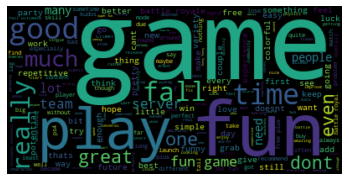

In [168]:
def plot_wordcloud(series,output_filename='wordcloud'):
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    wordcloud.to_file(output_filename + '.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plot_wordcloud(translated_df['review_text'],'overall-wordcloud')

def plot_wordcloud_top_n(df,number_of_reviews,score_column,data_column,output_filename):
    sliced_df = df.nlargest(number_of_reviews,score_column)
    plot_wordcloud(sliced_df[data_column],output_filename)

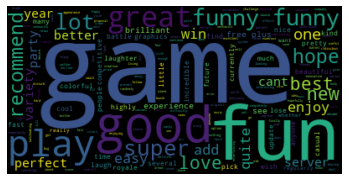

In [169]:
plot_wordcloud_top_n(translated_df,50,'positive sentiment score','review_text','positive-wordcloud')

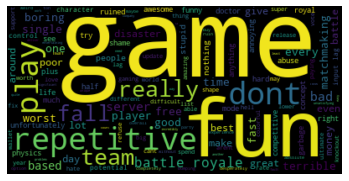

In [170]:
plot_wordcloud_top_n(translated_df,50,'negative sentiment score','review_text','negative-wordcloud')

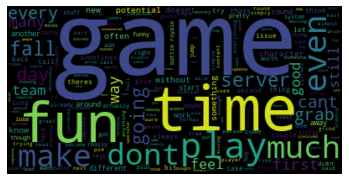

In [171]:
plot_wordcloud_top_n(translated_df,50,'neutral sentiment score', 'review_text', 'neutral-wordcloud')

In [172]:
features = ['overall sentiment score']
X = translated_df[features]
# lab_enc = preprocessing.LabelEncoder()
y = translated_df['new score']

In [173]:
X

,overall sentiment score
0,0.945
1,0.629
2,0.900
3,0.797
4,0.878
...,...
349,0.592
350,1.000
351,1.000
352,0.887


In [174]:
y

0      1
1      0
2      1
3      1
4      1
      ..
349    0
350    1
351    1
352    1
353    1
Name: new score, Length: 329, dtype: int64

In [175]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(classification_report(y_test, y_predict, zero_division=1))
    return accuracy

# Train-Test-Split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# KNN

In [177]:
knn = KNeighborsClassifier(n_neighbors=5)

print("Train-test-split Accuracy:", get_score(knn, X_train, X_test, y_train, y_test))

cv_score_dt = cross_val_score(knn, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_dt.mean()))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.82      0.84      0.83        63

    accuracy                           0.73        83
   macro avg       0.63      0.62      0.62        83
weighted avg       0.73      0.73      0.73        83

Train-test-split Accuracy: 0.7349397590361446

Cross Validation Accuracy: 0.6563170163170164


In [178]:
y_predict_prob_knn = knn.predict_proba(X_test)

print(y_predict_prob_knn[:,1])

[0.6 0.8 0.8 0.2 0.6 0.4 0.8 0.8 1.  0.8 0.8 0.8 0.8 0.8 1.  0.6 0.8 1.
 0.2 0.6 1.  0.8 1.  0.8 0.8 0.8 0.2 0.2 0.8 0.4 0.2 0.8 1.  0.8 0.8 1.
 0.8 0.4 0.8 1.  0.8 0.4 0.4 1.  0.6 0.8 0.4 1.  0.6 0.8 1.  1.  0.6 0.6
 0.8 1.  0.8 0.8 0.2 0.6 0.4 0.2 0.6 0.8 0.6 0.6 0.2 0.8 0.8 0.4 0.8 0.6
 0.4 0.8 0.8 0.2 1.  0.8 0.8 0.8 1.  0.8 0.8]


#### FPR and TPR

In [179]:
fpr_knn, tpr_knn, thresholds = metrics.roc_curve(y_test, y_predict_prob_knn[:,1], pos_label=1)

print(fpr_knn)
print("\n")
print(tpr_knn)

[0.   0.05 0.4  0.6  0.85 1.  ]


[0.         0.22222222 0.6984127  0.84126984 0.9047619  1.        ]


#### AUC

In [180]:
AUC_knn = metrics.auc(fpr_knn, tpr_knn)
print(AUC_knn)

0.6817460317460318


# Decision Tree

In [181]:
dt = DecisionTreeClassifier()

print("Train-test-split Accuracy:", get_score(dt, X_train, X_test, y_train, y_test))

cv_score_dt = cross_val_score(dt, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_dt.mean()))

              precision    recall  f1-score   support

           0       0.38      0.40      0.39        20
           1       0.81      0.79      0.80        63

    accuracy                           0.70        83
   macro avg       0.59      0.60      0.60        83
weighted avg       0.70      0.70      0.70        83

Train-test-split Accuracy: 0.6987951807228916

Cross Validation Accuracy: 0.7020512820512821


In [182]:
y_predict_prob_dt = dt.predict_proba(X_test)

print(y_predict_prob_dt[:,1])

[1.         0.85714286 0.85714286 1.         1.         1.
 1.         1.         1.         0.85714286 0.85714286 0.85714286
 1.         0.85714286 1.         1.         0.85714286 1.
 0.         1.         1.         0.85714286 1.         1.
 1.         0.85714286 0.         0.         0.         0.
 0.         0.85714286 1.         1.         0.85714286 1.
 0.85714286 1.         0.85714286 1.         0.         0.
 0.5        1.         0.5        1.         1.         1.
 0.5        0.5        1.         1.         1.         0.5
 1.         1.         0.85714286 0.85714286 0.         1.
 0.         0.         0.66666667 0.85714286 0.         0.
 0.         0.85714286 0.85714286 0.         0.85714286 1.
 1.         0.85714286 0.5        1.         1.         0.85714286
 1.         0.85714286 1.         0.85714286 0.85714286]


#### FPR and TPR

In [183]:
fpr_dt, tpr_dt, thresholds = metrics.roc_curve(y_test, y_predict_prob_dt[:,1], pos_label=1)

print(fpr_dt)
print("\n")
print(tpr_dt)

[0.   0.4  0.6  0.6  0.75 1.  ]


[0.         0.46031746 0.77777778 0.79365079 0.84126984 1.        ]


#### AUC

In [184]:
AUC_dt = metrics.auc(fpr_dt, tpr_dt)
print(AUC_dt)

0.5686507936507936


# Linear Regression

In [185]:
# linear = LinearRegression()

# linear.fit(X_train, y_train)

# y_predict_linear = linear.predict(X_test)

# accuracy_linear = accuracy_score(y_test, y_predict_linear.round(), normalize=False)

# print(classification_report(y_test, y_predict_linear, zero_division=1))

# print("Train-test-split Accuracy:", accuracy_linear)

# cv_score_dt = cross_val_score(linear, X, y, cv=5)

# print("\nCross Validation Accuracy:", (cv_score_dt.mean()))

In [186]:
# y_predict_prob_linear = linear.predict_proba(X_test)

# print(y_predict_prob_linear[:,1])

#### FPR and TPR

In [136]:
# fpr_linear, tpr_linear, thresholds = metrics.roc_curve(y_test, y_predict_prob_linear[:,1], pos_label=1)

# print(fpr_linear)
# print("\n")
# print(tpr_linear)

#### AUC

In [137]:
# AUC_linear = metrics.auc(fpr_linear, tpr_linear)
# print(AUC_linear)

# Logistic Regression

In [187]:
lr = LogisticRegression(max_iter=1000)

print("Train-test-split Accuracy:", get_score(lr, X_train, X_test, y_train, y_test))

cv_score_lr = cross_val_score(lr, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_lr.mean()))

              precision    recall  f1-score   support

           0       0.44      0.20      0.28        20
           1       0.78      0.92      0.85        63

    accuracy                           0.75        83
   macro avg       0.61      0.56      0.56        83
weighted avg       0.70      0.75      0.71        83

Train-test-split Accuracy: 0.7469879518072289

Cross Validation Accuracy: 0.7506759906759907


In [188]:
y_predict_prob_lr = lr.predict_proba(X_test)

print(y_predict_prob_lr[:,1])

[0.73455717 0.84163789 0.84163789 0.39828289 0.68574971 0.76909461
 0.79826596 0.7970019  0.78181876 0.84163789 0.84163789 0.84163789
 0.65755421 0.84163789 0.7190101  0.66863354 0.84163789 0.75441211
 0.35900398 0.66689616 0.79145619 0.84163789 0.70509651 0.59661365
 0.79573195 0.84163789 0.53123808 0.77461056 0.68349523 0.52343047
 0.34353962 0.84163789 0.74560293 0.65696617 0.84163789 0.74560293
 0.84163789 0.30358436 0.84163789 0.75730237 0.79952413 0.72943629
 0.55455427 0.78447862 0.55970684 0.59535655 0.58144927 0.73961572
 0.57380703 0.75003339 0.71848241 0.81297615 0.6492783  0.5571321
 0.69688977 0.70726302 0.84163789 0.84163789 0.33884556 0.64390987
 0.24311023 0.34471797 0.76395595 0.84163789 0.7782356  0.67725101
 0.6066235  0.84163789 0.84163789 0.7648961  0.84163789 0.6016292
 0.30913139 0.84163789 0.75149873 0.47843183 0.70618093 0.84163789
 0.65755421 0.84163789 0.7406199  0.84163789 0.84163789]


#### FPR and TPR

In [189]:
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

print(fpr_lr)
print("\n")
print(tpr_lr)

[0.   0.2  0.2  0.25 0.25 0.3  0.3  0.35 0.35 0.35 0.35 0.4  0.4  0.45
 0.45 0.5  0.5  0.55 0.55 0.6  0.6  0.75 0.75 0.8  0.8  0.85 0.85 0.95
 0.95 1.   1.  ]


[0.         0.31746032 0.38095238 0.38095238 0.47619048 0.47619048
 0.50793651 0.50793651 0.53968254 0.57142857 0.71428571 0.71428571
 0.76190476 0.76190476 0.77777778 0.77777778 0.82539683 0.82539683
 0.88888889 0.88888889 0.9047619  0.9047619  0.92063492 0.92063492
 0.95238095 0.95238095 0.96825397 0.96825397 0.98412698 0.98412698
 1.        ]


#### AUC

In [190]:
AUC_lr = metrics.auc(fpr_lr, tpr_lr)
print(AUC_lr)

0.6738095238095237


# Random Forest

In [191]:
rf = RandomForestClassifier()

print("Train-test-split Accuracy:", get_score(rf, X_train, X_test, y_train, y_test))

cv_score_rf = cross_val_score(rf, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_rf.mean()))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41        20
           1       0.81      0.83      0.82        63

    accuracy                           0.72        83
   macro avg       0.62      0.61      0.61        83
weighted avg       0.72      0.72      0.72        83

Train-test-split Accuracy: 0.7228915662650602

Cross Validation Accuracy: 0.7172027972027972


In [192]:
y_predict_prob_rf = rf.predict_proba(X_test)

print(y_predict_prob_rf[:,1])

[0.72       0.85585642 0.85585642 0.62       0.75       0.89
 0.97       0.98       1.         0.85585642 0.85585642 0.85585642
 0.99       0.85585642 1.         0.71       0.85585642 0.99
 0.01       0.68       0.99       0.85585642 1.         0.99
 0.98       0.85585642 0.22       0.02       0.41       0.07
 0.01       0.85585642 1.         0.92       0.85585642 1.
 0.85585642 0.76       0.85585642 1.         0.33       0.23
 0.46461905 1.         0.48461905 0.96       0.665      1.
 0.48002381 0.56       1.         1.         0.88       0.48461905
 0.99       1.         0.85585642 0.85585642 0.08       0.75
 0.33       0.01       0.65263492 0.85585642 0.28       0.1
 0.01       0.85585642 0.85585642 0.14678571 0.85585642 0.71
 0.76       0.85585642 0.56       0.66       1.         0.85585642
 0.99       0.85585642 1.         0.85585642 0.85585642]


#### FPR and TPR

In [193]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_predict_prob_rf[:,1], pos_label=1)

print(fpr_rf)
print("\n")
print(tpr_rf)

[0.   0.   0.15 0.2  0.2  0.4  0.5  0.5  0.55 0.55 0.6  0.6  0.6  0.7
 0.7  0.75 0.75 0.75 0.75 0.8  0.8  0.9  0.9  1.  ]


[0.         0.20634921 0.25396825 0.26984127 0.34920635 0.66666667
 0.6984127  0.71428571 0.73015873 0.74603175 0.74603175 0.79365079
 0.82539683 0.82539683 0.84126984 0.84126984 0.85714286 0.88888889
 0.93650794 0.93650794 0.95238095 0.95238095 0.96825397 1.        ]


#### AUC

In [194]:
AUC_rf = metrics.auc(fpr_rf, tpr_rf)
print(AUC_rf)

0.655952380952381


# SVM

In [195]:
svm1 = svm.SVC(probability=True)

print("Train-test-split Accuracy:", get_score(svm1, X_train, X_test, y_train, y_test))

cv_score_svm = cross_val_score(svm1, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_svm.mean()))

              precision    recall  f1-score   support

           0       0.57      0.40      0.47        20
           1       0.83      0.90      0.86        63

    accuracy                           0.78        83
   macro avg       0.70      0.65      0.67        83
weighted avg       0.76      0.78      0.77        83

Train-test-split Accuracy: 0.7831325301204819

Cross Validation Accuracy: 0.7628438228438229


In [196]:
y_predict_prob_svm = svm1.predict_proba(X_test)

print(y_predict_prob_svm[:,1])

[0.79023984 0.78640815 0.78640815 0.2157767  0.79139244 0.78564644
 0.78958111 0.78932122 0.78660459 0.78640815 0.78640815 0.78640815
 0.76987699 0.78640815 0.79336885 0.78119367 0.78640815 0.78652781
 0.22660805 0.77968453 0.78820837 0.78640815 0.7946481  0.62471861
 0.78906099 0.78640815 0.3743162  0.78587098 0.79049515 0.35090655
 0.23254634 0.78640815 0.78793878 0.76915981 0.78640815 0.78793878
 0.78640815 0.24944447 0.78640815 0.78619354 0.7898393  0.79135618
 0.45754549 0.7869867  0.47788596 0.61989388 0.56536647 0.7891437
 0.53469428 0.7871627  0.79345341 0.79217027 0.75862823 0.46766914
 0.79414565 0.79460314 0.78640815 0.78640815 0.23444093 0.74994849
 0.2756132  0.23207636 0.78571545 0.78640815 0.78618112 0.78733572
 0.65702136 0.78640815 0.78640815 0.78568279 0.78640815 0.64376189
 0.24701735 0.78640815 0.78693421 0.25217741 0.79463398 0.78640815
 0.76987699 0.78640815 0.78893234 0.78640815 0.78640815]


#### FPR and TPR

In [197]:
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test, y_predict_prob_svm[:,1], pos_label=1)

print(fpr_svm)
print("\n")
print(tpr_svm)

[0.   0.   0.   0.05 0.05 0.1  0.1  0.15 0.35 0.35 0.4  0.4  0.45 0.45
 0.5  0.5  0.55 0.55 0.6  0.6  0.75 0.75 0.8  0.8  0.85 0.85 0.95 0.95
 1.   1.  ]


[0.         0.01587302 0.04761905 0.04761905 0.22222222 0.22222222
 0.36507937 0.36507937 0.68253968 0.74603175 0.74603175 0.76190476
 0.76190476 0.79365079 0.79365079 0.82539683 0.82539683 0.88888889
 0.88888889 0.9047619  0.9047619  0.92063492 0.92063492 0.95238095
 0.95238095 0.96825397 0.96825397 0.98412698 0.98412698 1.        ]


#### AUC

In [198]:
AUC_svm = metrics.auc(fpr_svm, tpr_svm)
print(AUC_svm)

0.7126984126984127


In [199]:
# clf = MLPClassifier(hidden_layer_sizes = (30,), random_state=1, learning_rate_init = 0.02, solver='adam',
#                 alpha=1, verbose=True, activation='logistic')

# cv_accuracy = cross_val_score(clf, X, y, cv = 10, scoring = 'accuracy', verbose = True)

In [200]:
# ann_accuracy = cv_accuracy.mean()

# print("Accuracy", ann_accuracy)

In [201]:
# neurons = [(x,) for x in range(5, 251, 5)]

# param_grid = dict(hidden_layer_sizes = neurons)

# clf_1 = MLPClassifier(random_state=1, learning_rate_init = 0.02, solver='adam',
#                 alpha=1, verbose=True, activation='logistic')

# grid = GridSearchCV(clf_1, param_grid, scoring = 'accuracy', cv = 10)

# grid_result = grid.fit(X, y)

In [202]:
# print(grid.best_score_)
# print(grid.best_params_)

# Roc Curves

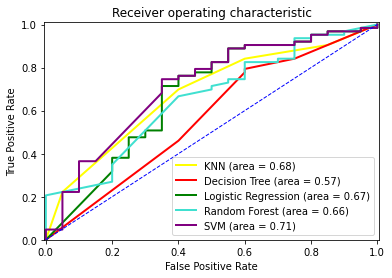

In [203]:
# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
%matplotlib inline

plt.figure()

plt.plot(fpr_knn, tpr_knn, color='yellow', lw=2, 
         label='KNN (area = %0.2f)' % AUC_knn)

plt.plot(fpr_dt, tpr_dt, color='red', lw=2, 
         label='Decision Tree (area = %0.2f)' % AUC_dt)

# plt.plot(fpr_linear, tpr_linear, color='yellow', lw=2, 
#          label='Linear Regression (area = %0.2f)' % AUC_linear)

plt.plot(fpr_lr, tpr_lr, color='green', lw=2, 
         label='Logistic Regression (area = %0.2f)' % AUC_lr)

plt.plot(fpr_rf, tpr_rf, color='turquoise', lw=2, 
         label='Random Forest (area = %0.2f)' % AUC_rf)

plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, 
         label='SVM (area = %0.2f)' % AUC_svm)

# plt.plot(fpr_rf, tpr_rf, color='yellow', lw=2, 
#          label='Random Forest (area = %0.2f)' % AUC_rf)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()